In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

In [2]:
# from fair import *
# from fair.scripts.data_retrieval import *

## Define Functions

In [3]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(T, T_perturb, W, discount_function, gamma=2, D0=0.00267):
    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturb**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [4]:
## calculate abatement given a carbon price

# def abatement(P, P0, P_h=44, r=20, s=18, Am=1.1):
#     A = Am/(1+((P-P0)/P_h)**(-r/s))
    
#     return A

# P_100 = 500

# def abatement(P, P0, r=0.04, P_h=100, s=0.05, P_100=P_100):
#     if P0 >= P_h:
#         print("P0 is greater than P_h")

#     Am = 1+((P_100-P0)/(P_h-P0))**(-s/r)
#     A = Am/(1+((P-P0)/(P_h-P0))**(-s/r))
        
#     return A

P_50 = 100  # 187.5 * 0.7625000000000001
P_100 = 500  # 187.5

# P_50=100, s=0.05, r=0.04, P_100=500

def abatement(P, P0, P_50=P_50, r=0.04, s=0.05, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [5]:
# ## Nick's function to get SSP emissions data (use to get historical data to 2019)

# def get_ssp_emissions(ssp, end_year = 2019):
    
#     emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:end_year]

#     ## rebase emission-driven forcings & species with natural emissions included in RCMIP to zero @ 1750
#     rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
#     emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]
    
#     return emms

In [6]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [7]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [8]:
start_year = 1750
last_historical_year = 2019
end_year = 2500

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [9]:
delta_T = 2
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [10]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

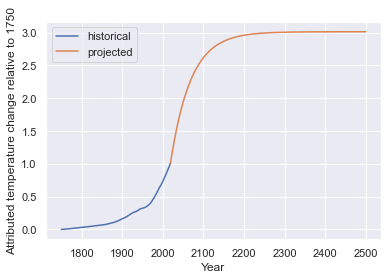

In [11]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## Total Consumption

In [12]:
consumption_growth = 0.02
W0 = 80

W = []

# for i in range(len(years)):
#     W.append(W0*consumption_growth**(i-(last_historical_year - start_year)))
    
for i in range(len(years)):
    W.append(W0*np.exp(consumption_growth*(i-(last_historical_year - start_year))))

W = np.asarray(W)

(0.0, 400.0)

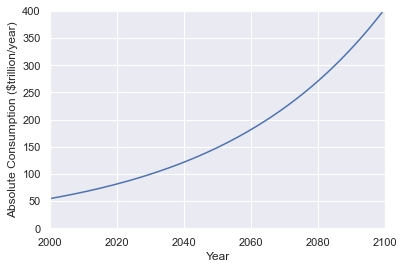

In [13]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
plt.xlim(2000, 2100)
plt.ylim(0, 400)

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [14]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2200
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

# consumption_discount = 0.035
consumption_discount = consumption_growth + 0.015

SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
    cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
    SCC = cost/(10**9)
    SCC_list.append(SCC)

In [15]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [16]:
SCC_array

array([  30.95754246,   31.7933376 ,   32.63598364,   33.50622536,
         34.38284496,   35.28893625,   36.200913  ,   37.14431394,
         38.09308769,   39.07531768,   40.06238683,   41.08502709,
         42.11195093,   43.17664693,   44.24504814,   45.35351225,
         46.46507945,   47.61909364,   48.77558407,   49.97700271,
         51.18024501,   52.43099782,   53.68289491,   54.98499002,
         56.28752211,   57.64304923,   58.99827694,   60.40941064,
         61.8194783 ,   63.28848145,   64.75562041,   66.28484779,
         67.81138   ,   69.40328196,   70.99162361,   72.64874998,
         74.30141528,   76.02641937,   77.74602458,   79.54166735,
         81.33093483,   83.20008926,   85.0618518 ,   87.00750741,
         88.94471265,   90.96998019,   92.9856953 ,   95.09381166,
         97.1912281 ,   99.3855614 ,  101.56799999,  103.85205483,
        106.12297093,  108.50039394,  110.86338289,  113.33796845,
        115.79677117,  118.37246732,  120.93097621,  123.61189

Text(0, 0.5, 'SCC ($)')

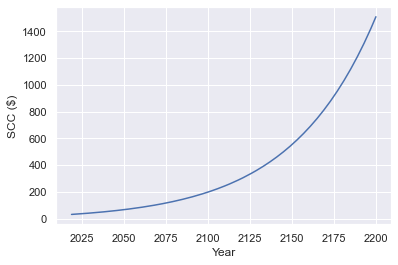

In [17]:
plt.plot(year_of_perturbation, SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [18]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

### Fit SCC line to forecast

In [19]:
# plt.plot(year_of_perturbation, SCC_array)
# plt.xlabel("Year")
# plt.ylabel("SCC ($)")
# plt.yscale("log")

In [20]:
# log_SCC = np.log(SCC_array)

In [21]:
# ## add linear fit
# X = sm.add_constant(year_of_perturbation) # add a constant to fit
# results = sm.OLS(log_SCC, X).fit() # save results of fit

In [22]:
# #Plot with Fit & Summary 
# plt.plot(year_of_perturbation, log_SCC)
# plt.plot(year_of_perturbation, results.params[0]+results.params[1]*year_of_perturbation, 'r' , label='fitted_line')
# plt.xlabel("Year")
# plt.ylabel("ln(SCC)")

In [23]:
# SCC_forecasted = np.exp(results.params[0]+results.params[1]*T_forecast_years)

In [24]:
T_forecast_length

482

In [25]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(year_of_perturbation):
        SCC_forecasted.append(SCC_array[i])
    else:
        SCC_forecasted.append(SCC_array[-1])

SCC_forecasted = np.array(SCC_forecasted)

In [26]:
SCC_forecasted

array([  30.95754246,   31.7933376 ,   32.63598364,   33.50622536,
         34.38284496,   35.28893625,   36.200913  ,   37.14431394,
         38.09308769,   39.07531768,   40.06238683,   41.08502709,
         42.11195093,   43.17664693,   44.24504814,   45.35351225,
         46.46507945,   47.61909364,   48.77558407,   49.97700271,
         51.18024501,   52.43099782,   53.68289491,   54.98499002,
         56.28752211,   57.64304923,   58.99827694,   60.40941064,
         61.8194783 ,   63.28848145,   64.75562041,   66.28484779,
         67.81138   ,   69.40328196,   70.99162361,   72.64874998,
         74.30141528,   76.02641937,   77.74602458,   79.54166735,
         81.33093483,   83.20008926,   85.0618518 ,   87.00750741,
         88.94471265,   90.96998019,   92.9856953 ,   95.09381166,
         97.1912281 ,   99.3855614 ,  101.56799999,  103.85205483,
        106.12297093,  108.50039394,  110.86338289,  113.33796845,
        115.79677117,  118.37246732,  120.93097621,  123.61189

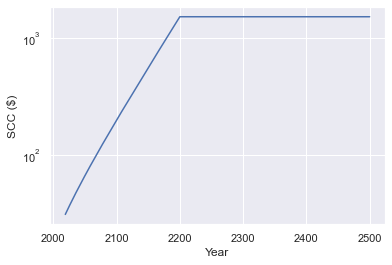

In [27]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [28]:
P0 = SCC_forecasted[0]

In [29]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_84925/3748283578.py:33: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

In [30]:
# abatement(P=np.array([50]), P0=P0, r=consumption_discount, P_100=200)

In [31]:
# P0

In [32]:
# r=0.04
# s=0.029687500000000006
# (P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)

In [33]:
# ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)

In [34]:
T_forecast_years[last_perturbed_year - 2019]

2200

In [35]:
forecasted_abatement[last_perturbed_year - 2019]

1.0827512776750639

Text(0, 0.5, 'Abatement')

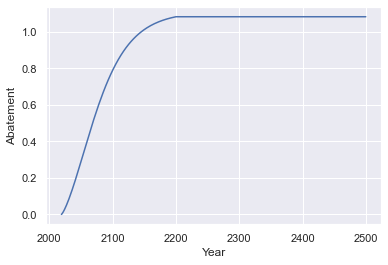

In [36]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [37]:
# # choose ssp to use
# ssp='ssp245'

# # get emissions data using imported scripts + convert into FaIRv2.0.0-alpha multiindex format
# ssp_emms = pd.concat([get_ssp_emissions(ssp)],axis=1,keys=[ssp])

In [38]:
# ssp_emms["ssp245"].to_csv("ssp245.csv")

In [39]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [40]:
# ssp245_CO2_past = ssp_emms["ssp245"]["carbon_dioxide"]*(44/12)  

In [41]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [42]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [43]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

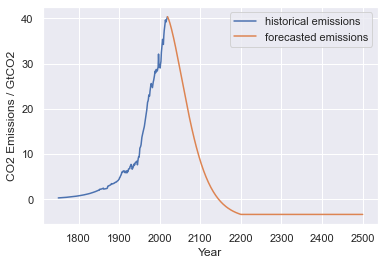

In [44]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [45]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [46]:
# cumulative_emissions

In [47]:
# len(cumulative_emissions)

In [48]:
# cumulative_emissions = []

# for i in range(len(T_forecast_years)):
#     area = simps(forecasted_emissions[:i+1], dx=1)
#     cumulative_emissions.append(area)

In [49]:
# cumulative_emissions_array = np.asarray(cumulative_emissions)

In [50]:
temperature_change = T_TCRE*cumulative_emissions_array

In [51]:
temperature_change_plateau = np.array(temperature_change, copy=True)

for i in range(len(temperature_change_plateau)):
    if i > np.argmax(temperature_change_plateau):
        temperature_change_plateau[i] = max(temperature_change_plateau)

In [52]:
max(temperature_change)

1.1655260211430356

In [53]:
T_forecast_iteration0 = T_2019 + temperature_change
T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

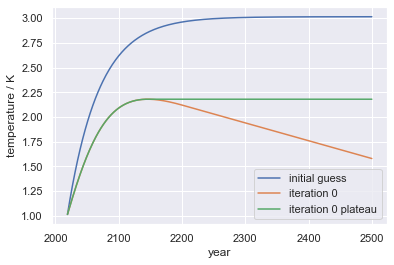

In [54]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [55]:
T_forecast_first_loop = T_forecast_iteration0_plateau
T_forecast_iteration = T_forecast_iteration0_plateau

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_84925/3748283578.py:33: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_84925/3748283578.py:33: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_84925/3748283578.py:33: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_84925/3748283578.py:33: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_84925/3748283578.py:33: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


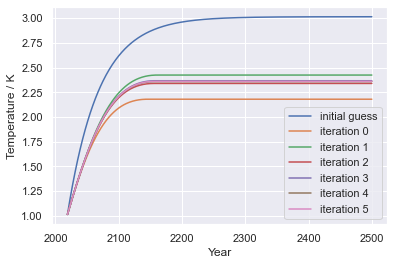

In [56]:
num_of_iterations = 5

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        ## define discount function
        num_of_years = len(years)

#         consumption_discount = 0.035
        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
        cost = cost_of_perturbation(T=T_iteration, T_perturb=T_perturbed, W=W, discount_function=discount_function)
        SCC = cost/(10**9)
        SCC_list.append(SCC)

    SCC_array = np.asarray(SCC_list)
#     log_SCC = np.log(SCC_array)

#     ## add linear fit
#     X = sm.add_constant(year_of_perturbation) # add a constant to fit
#     results = sm.OLS(log_SCC, X).fit() # save results of fit

#     SCC_forecasted = np.exp(results.params[0]+results.params[1]*T_forecast_years)
    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(year_of_perturbation):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(SCC_array[-1])

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

#     cumulative_emissions = []

#     for i in range(len(T_forecast_years)):
#         area = simps(forecasted_emissions[:i+1], dx=1)
#         cumulative_emissions.append(area)

#     cumulative_emissions_array = np.asarray(cumulative_emissions)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    # to return to the previous method remove for loop and T_forecast_iteration = T_2019 + temperature_change
    temperature_change_plateau = np.array(temperature_change, copy=True)
    for i in range(len(temperature_change_plateau)):
        if i > np.argmax(temperature_change_plateau):
            temperature_change_plateau[i] = max(temperature_change_plateau)

    T_forecast_iteration = T_2019 + temperature_change_plateau
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [57]:
## peak Temperature
max(T_forecast_iteration)

2.36007902607154

under default settings: 2.0439370757585076

In [58]:
SCC_forecasted[0]

25.880803313121696